In [2]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
import pickle
import umap

# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('../report_plots/report.mplstyle')


# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.13.1+cu117
Using device: cuda:0


# Figure 9

In [3]:
def load_tc_data(datadir, mouse_id, session_id, subset, phase='wake'):
    data = np.load(datadir + f'{mouse_id}_{session_id}_{phase}_{subset}.npz')
    tc_rates = data['tuning_curves_rates']  # (neurons, num_cov, steps)
    tc_FF = data['tuning_curves_FF']  # (neurons, num_cov, steps)
    tc_cov = data['tuning_curves_covariates']  # (num_cov, steps)
    
    return tc_rates, tc_FF, tc_cov

def tuning_index(hd_stat):
    """Compute the tuning index of a tuning curve with a given statistics of spike count distributions."""
    tc_max = np.max(hd_stat, axis=-1)
    tc_min = np.min(hd_stat, axis=-1)

    return (tc_max - tc_min) / (tc_max + tc_min)

def plot_pca(components, labels, label_names, plot3d=False, ax=None, colors=None, s=6, legendsize=6):
    
    sorted_indices = np.argsort(labels)
    sorted_components = components[sorted_indices]
    
    num_neurons_per_label = []
    for i, name in enumerate(label_names):
        num_neurons_per_label.append(np.where(labels==i)[0].size)
    cum_neurons = np.cumsum(np.array(num_neurons_per_label))
    cum_neurons = np.insert(cum_neurons, 0, 0)

    # define the colormap
    if colors is None:
        colors = list(matplotlib.colors.BASE_COLORS)

    if ax is None:
        if plot3d:
            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')
        else:
            _, ax = plt.subplots()
    if not plot3d:
        for i, label in enumerate(label_names):
                ax.scatter(sorted_components[cum_neurons[i]:cum_neurons[i+1], 0], sorted_components[cum_neurons[i]:cum_neurons[i+1], 1], c=colors[i], label=label, s=s,  alpha=0.5)
        ax.set_title('First 2 principal components of neuronal features')
    else:
        for i, label in enumerate(label_names):
                ax.scatter(sorted_components[cum_neurons[i]:cum_neurons[i+1], 0], sorted_components[cum_neurons[i]:cum_neurons[i+1], 1], sorted_components[cum_neurons[i]:cum_neurons[i+1], 2], c=colors[i], label=label, s=s,  alpha=0.5)
        ax.set_title('First 3 principal components of neuronal features')
    #ax.legend(prop={'size': legendsize}, loc='upper right')
    ax.set_xlabel('component 1')
    ax.set_ylabel('component 2')
    if plot3d:
        ax.set_zlabel('3rd PC')

In [4]:
tc_datadir = '/scratches/ramanujan_2/vn283/HDC_PartIII/tc_data/'
datadir = data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'

phase='wake'
bin_size=160
single_spikes=False

mice_sessions = {
    'Mouse12': ['120806'],
    'Mouse17': ['130125', '130128', '130131', '130202', '130203'],
    'Mouse20': ['130514', '130515', '130516', '130517'],
    'Mouse24': ['131213', '131217', '131218'],
    'Mouse25': ['140124', '140128', '140129'],
    'Mouse28': ['140310']
} 

num_hdc = {}
num_nonhdc = {}
features_rates = np.empty((0, 6))  # we have 6 covariates, so 6 features
features_FF = np.empty((0, 6))

labels_brain_regions = np.empty(0)

for mouse_id in mice_sessions.keys():
    num_hdc[mouse_id] = {}
    num_nonhdc[mouse_id] = {}
    for session_id in mice_sessions[mouse_id]:
        dataset = HDC.get_dataset(mouse_id, session_id, phase, 'hdc', bin_size, single_spikes, path=data_dir)
        neuron_regions = dataset['metainfo']['neuron_regions']
        labels_brain_regions = np.concatenate((labels_brain_regions, neuron_regions))
        for subset in ['hdc', 'nonhdc']:
            tc_rates, tc_FF, tc_cov = load_tc_data(tc_datadir, mouse_id, session_id, subset)
            ti_rates = tuning_index(tc_rates)  # (neurons, num_cov)
            ti_FF = tuning_index(tc_FF)
            
            if subset == 'hdc':
                num_hdc[mouse_id][session_id] = ti_rates.shape[0]
            else:
                num_nonhdc[mouse_id][session_id] = ti_rates.shape[0]
                
            features_rates = np.concatenate((features_rates, ti_rates), axis=0)
            features_FF = np.concatenate((features_FF, ti_FF), axis=0)

labels_hdc = []

for mouse_id in mice_sessions.keys():
    for session_id in mice_sessions[mouse_id]:
        labels_hdc += [1]*num_hdc[mouse_id][session_id] + [0]*num_nonhdc[mouse_id][session_id]

labels_mice = []

for i, mouse_id in enumerate(mice_sessions.keys()):
    for session_id in mice_sessions[mouse_id]:
        labels_mice += [i]*(num_hdc[mouse_id][session_id] + num_nonhdc[mouse_id][session_id])
        
filter_hdc = np.array(labels_hdc).astype(bool)


units:  85  hdc units:  22
units:  21  hdc units:  2
units:  46  hdc units:  7
units:  50  hdc units:  7
units:  55  hdc units:  5
units:  59  hdc units:  7
units:  11  hdc units:  2
units:  13  hdc units:  4
units:  17  hdc units:  4
units:  22  hdc units:  6
units:  28  hdc units:  5
units:  40  hdc units:  11
units:  43  hdc units:  11
units:  36  hdc units:  10
units:  32  hdc units:  5
units:  33  hdc units:  11
units:  56  hdc units:  14


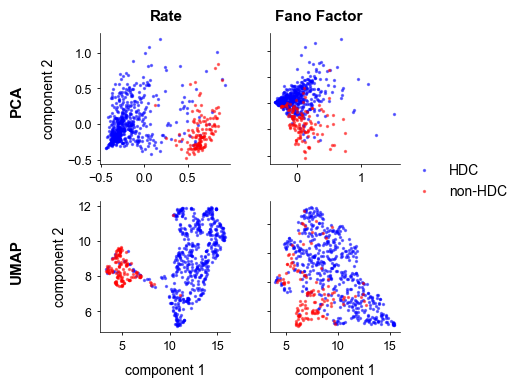

In [15]:
# PCA and UMAP on hand-picked features    

fig = plt.figure(figsize=(5,4))

s=2
legendsize=10

pca = PCA()
pca.fit(features_rates)
components_rates = pca.transform(features_rates)
pca.fit(features_FF)
components_FF = pca.transform(features_FF)


widths=heights=[1,1]
gs = gridspec.GridSpec(2, 2, fig, left=0.3, wspace=0.3, width_ratios=widths, height_ratios=heights)

ax1 = fig.add_subplot(gs[0,0])
plot_pca(components_rates, np.array(labels_hdc), ['HDC', 'non-HDC'], colors=['b', 'r'], ax=ax1, s=s)
ax1.legend().remove()
ax1.set_xlabel('')
ax1.set_title('')
ax1.set_box_aspect(1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)


ax2 = fig.add_subplot(gs[0,1])
plot_pca(components_FF, np.array(labels_hdc), ['HDC', 'non-HDC'], colors=['b', 'r'], ax=ax2, s=s)
#ax2.legend(prop={'size': legendsize}, loc='upper right')
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.set_yticklabels([])
ax2.set_title('')
ax2.set_box_aspect(1)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend(prop={'size': legendsize}, loc='upper center', bbox_to_anchor=(1.45, 0.1), frameon=False)


ax3 = fig.add_subplot(gs[1,0])
reducer = umap.UMAP(n_neighbors=20)
embedding_rates = reducer.fit_transform(features_rates)
plot_pca(embedding_rates, np.array(labels_hdc), ['HDC', 'non-HDC'], colors=['b', 'r'], ax=ax3, s=s)
ax3.set_title('')
ax3.legend().remove()
ax3.set_box_aspect(1)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

ax4 = fig.add_subplot(gs[1,1])
reducer2 = umap.UMAP(n_neighbors=15, min_dist=0.3)
embedding_ff = reducer2.fit_transform(features_FF)
plot_pca(embedding_ff, np.array(labels_hdc), ['HDC', 'non-HDC'], colors=['b', 'r'], ax=ax4, s=s)
ax4.legend().remove()
ax4.set_ylabel('')
ax4.set_yticklabels([])
ax4.set_title('')
ax4.set_box_aspect(1)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

fig.text(0.12, 0.7, 'PCA', rotation=90, va='center', size=11, fontweight='bold')
fig.text(0.12, 0.3, 'UMAP', rotation=90, va='center', size=11, fontweight='bold')
fig.text(0.4, 0.9, 'Rate', size=11, fontweight='bold')
fig.text(0.65, 0.9, 'Fano Factor', size=11, fontweight='bold')

fig.savefig("/homes/vn283/UCM-interpret/figures/PCA.pdf", format="pdf", bbox_inches="tight")